In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt

import Project_library as pl

## Auto Regressive model for data demand change

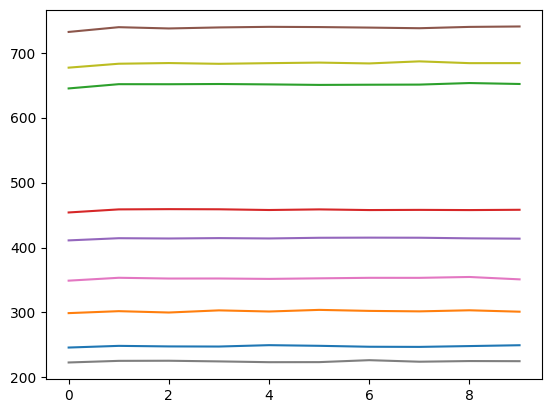

In [2]:
def ar1_process(demand_over_time: jnp.ndarray, variability : float, time_slots : int, ar_weight : float, key : jnp.ndarray) -> jnp.ndarray:
    white_noise = jrandom.normal(key, demand_over_time.shape)  # Generate white noise

     # Add the initial demand to the white noise

    for i in range(1, time_slots):
        demand_over_time = demand_over_time.at[i].set(ar_weight * demand_over_time[i-1] + white_noise[i]+ demand_over_time[0])

    return demand_over_time


# Demanded bit rate changes with time
# Demand is intialised
for k in range(1, 10):
    demand = jnp.array([jrandom.randint(jrandom.PRNGKey(k), (1), minval=200, maxval = 750)])
    
    # The reconfiguration period is 30 seconds
    reconfiguration_period = 30
    # The number of reconfigurations is 10
    time_slots = 10

    time_slot_duration =int( reconfiguration_period / time_slots)

    # Setup array with demand over time
    demand_over_time = jnp.zeros((time_slots, demand.shape[0]))

    demand_over_time = demand_over_time.at[0].set(demand[0].item())

    #print(demand_over_time)

    key, subkey = jrandom.split(jrandom.PRNGKey(k))
    # Calculate the AR(1) process for the demand

    demand_over_time = ar1_process(demand_over_time, 1, time_slots, 0.01, subkey)

    plt.plot(demand_over_time)

## Markov Distribution

In [3]:
import contextlib
@contextlib.contextmanager
def timing_function(indent):
    """
    A context manager to time a block of code.
    """
    import time
    start_time = time.time()
    yield
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{' ' * indent}Elapsed time: {elapsed_time:.2f} seconds")

In [4]:
def markov_step(state, key, A):
    key, subkey = jrandom.split(key)
    probs = A[state]  # Transition probabilities from current state
    next_state = jrandom.choice(subkey, A.shape[0], p=probs)
    return next_state, next_state

# Function for state change given A
def user_state_change(state_change_matrix : jnp.ndarray, state : int, time_series : jnp.ndarray, key : jnp.ndarray) -> jnp.ndarray:
    # Create a copy of the state change matrix
    
    key = jrandom.split(key, time_series.shape[0]-1)

    def scan_fn(state,key):
        return markov_step(state, key, state_change_matrix)
    
    _, states = jax.lax.scan(scan_fn, state, key)

    return jnp.concatenate([jnp.array([state]), states])

seed = 42

key = jrandom.PRNGKey(seed)

time_series = jnp.zeros((time_slots, 1))
# Create a state change matrix

state_change_matrix = jnp.array([[0.1, 0.9], 
                                 [0.3, 0.7]])

# Intial state is 0
state = 0
time_series = user_state_change(state_change_matrix, state, time_series, key)

time_series, time_series.shape[0]

(Array([0, 1, 1, 1, 0, 0, 1, 1, 1, 1], dtype=int32), 10)

In [5]:
seed = 10

key = jrandom.PRNGKey(seed)
# Number of users in a cell
num_users = jrandom.choice(key, jnp.arange(10,20))

user_rate = 100e3 # 100 kbps

time_series = jnp.zeros((time_slots, 1))

series = []

# Loop over the number of users, can compute the demand based on the state change of the users.
for i in range(num_users):
    key, subkey = jrandom.split(key)
    # Create a state change matrix
    state_change_matrix = jnp.array([[0.3, 0.7], 
                                     [0.3, 0.7]])
    # Intial state is 1
    state = 1
    series.append(user_state_change(state_change_matrix, state, time_series, key))

series

[Array([1, 0, 0, 1, 0, 1, 1, 1, 1, 0], dtype=int32),
 Array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int32),
 Array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0], dtype=int32),
 Array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1], dtype=int32),
 Array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1], dtype=int32),
 Array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1], dtype=int32),
 Array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0], dtype=int32),
 Array([1, 0, 1, 0, 1, 1, 1, 0, 1, 1], dtype=int32),
 Array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32),
 Array([1, 1, 0, 1, 1, 0, 1, 0, 0, 1], dtype=int32),
 Array([1, 1, 1, 0, 1, 1, 0, 0, 1, 0], dtype=int32),
 Array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0], dtype=int32),
 Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)]

Text(0.5, 1.0, 'Demand Over Time')

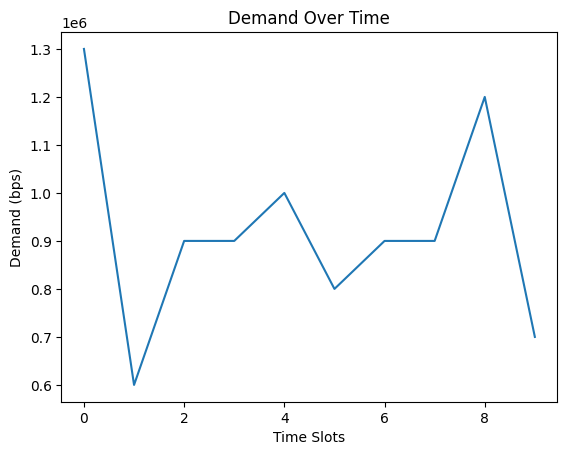

In [6]:
# Sum along the columns to get the total demand
total_demand = jnp.sum(jnp.array(series), axis=0)
total_demand = total_demand.flatten()*100e3

total_demand
# Plot the demand over time
plt.plot(total_demand, label='Total Demand')
plt.xlabel('Time Slots')
plt.ylabel('Demand (bps)')
plt.title('Demand Over Time')

In [7]:
earth_radius = 6371  # in kilometers

satellite_height = 600  # in meters

# Place a satellite at the
satellite_position = jnp.array([ satellite_height + earth_radius ,0, 0])  # in kilometers

# Calculate the viewing angle
lat_range, lon_range, _, _,_, angle_of_interest = pl.visible_angle(jnp.deg2rad(40), satellite_position)

lon_range = jnp.array(lon_range)
lon_range = lon_range.at[1].set(lon_range[1]+(lon_range[1]-lon_range[0]))

# Define the grid size and resolution, with 50 km size at the equator
grid_size = 50  # in kilometers
# Leading to an angle of 
angle_of_cell_size = grid_size/earth_radius

# Calculate the number of cells in the grid
num_cells_lat = int((lat_range[1] - lat_range[0]) / angle_of_cell_size)
num_cells_lon = int((lon_range[1] - lon_range[0]) / angle_of_cell_size)

# Create a grid of cells
mesh_grid = pl.generate_latitude_longitude_points(num_cells_lat, num_cells_lon, lat_range, lon_range)

# Recover list of lat and lon points
lat_points, long_points = mesh_grid[0][:,0], mesh_grid[1][0,:]

print(jnp.rad2deg(angle_of_interest))

print(lat_points)
print(long_points)

5.5641456
[-0.0930663  -0.08497357 -0.07688085 -0.06878813 -0.06069541 -0.05260269
 -0.04450996 -0.03641725 -0.02832452 -0.0202318  -0.01213908 -0.00404635
  0.00404637  0.01213909  0.02023181  0.02832453  0.03641725  0.04450997
  0.05260269  0.06069542  0.06878814  0.07688086  0.08497358  0.0930663 ]
[-0.09314887 -0.08522131 -0.07729375 -0.06936619 -0.06143862 -0.05351105
 -0.04558349 -0.03765593 -0.02972837 -0.0218008  -0.01387324 -0.00594567
  0.00198189  0.00990945  0.01783702  0.02576458  0.03369214  0.0416197
  0.04954727  0.05747483  0.0654024   0.07332997  0.08125752  0.0891851
  0.09711266  0.10504021  0.11296779  0.12089534  0.12882291  0.13675047
  0.14467804  0.1526056   0.16053316  0.16846073  0.17638828  0.18431586
  0.19224341  0.20017098  0.20809855  0.21602611  0.22395366  0.23188123
  0.2398088   0.24773636  0.2556639   0.2635915   0.27151906  0.2794466
  0.28737417]


In [ ]:
visible_area_of_sat_one = pl.calculate_if_cells_within_visible_area(jnp.rad2deg(lat_points),jnp.rad2deg(long_points), 0, 0, 6000, jnp.rad2deg(angle_of_interest))

print(visible_area_of_sat_one)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


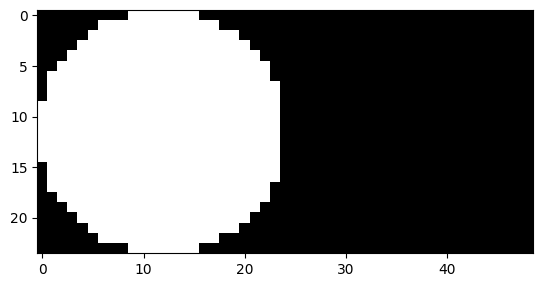

In [9]:
import matplotlib.pyplot as plt
plt.imshow(visible_area_of_sat_one, cmap='gray')



In [10]:
visible_area_of_sat_two = pl.calculate_if_cells_within_visible_area(jnp.rad2deg(lat_points),jnp.rad2deg(long_points), 0, 7.6, 6000, jnp.rad2deg(angle_of_interest))

print(visible_area_of_sat_two)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


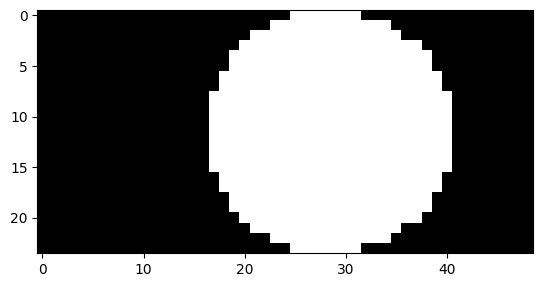

In [11]:
plt.imshow(visible_area_of_sat_two, cmap='gray')

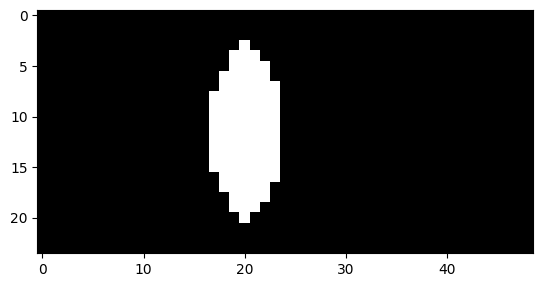

In [12]:
# The intersection between the two visible areas
intersection = jnp.logical_and(visible_area_of_sat_one, visible_area_of_sat_two)
plt.imshow(intersection, cmap='gray')

### Distribute the users across cells according to a random process, optimise the allocation.
### Check what happens over time

In [13]:
mesh_grid_comb = jnp.stack(mesh_grid, axis=-1)
mesh_grid_comb.shape

seed = 10

key = jrandom.PRNGKey(seed)

base_user_demand = 100e3

# Set a high vs low density for the cells

cells = []


for i in range(mesh_grid_comb.shape[0]):
    cells_row = []
    for j in range(mesh_grid_comb.shape[1]):
        
        density = jrandom.choice(key, jnp.array([3, 8]))

        key, subkey = jrandom.split(key)
        user_list = []
        #print([pl.User(mesh_grid_comb[i,j,0], mesh_grid_comb[i,j,1], x, jrandom.choice(key, jnp.array([0,1]), p=jnp.array([0.1,0.9]))) for x in range(density)])
        for x in range(density):
            key, subkey = jrandom.split(key)
            #print(jrandom.choice(key, jnp.array([0,1]), p=jnp.array([0.1,0.9])))
            user_list.append(pl.User(mesh_grid_comb[i,j,0], mesh_grid_comb[i,j,1], x, jrandom.choice(key, jnp.array([0,1])*base_user_demand, p=jnp.array([0.25,0.75]))))
        
        cells_row.append(pl.square_cell(
            lat = mesh_grid_comb[i,j,0], 
            longi = mesh_grid_comb[i,j,1],
            lat_width=[],
            longi_width=[],
            density=density,
            id=i*mesh_grid_comb.shape[1]+j,
            users= user_list,
            users_amount=density
        ))

        key, subkey = jrandom.split(key)
    cells.append(cells_row)

In [14]:
print(len(cells[0]))
print(len(cells))

49
24


### Lets try to run the optimisation on the single satellite, and the cells it can see.

In [15]:
import pulp

def calculate_demand_of_cell(cell : pl.square_cell) -> float:
    # Calculate the demand of the cell based on the users in it
    demand = 0
    for user in cell.users:
        demand += user.demand

    return demand

calculate_demand_of_cell(cells[0][0])

Array(500000., dtype=float32, weak_type=True)

In [16]:
demand_list = []

for i in range(len(cells)):
   
    for j in range(len(cells[i])):
        if visible_area_of_sat_one[i,j]:
            demand = calculate_demand_of_cell(cells[i][j])
            demand_list.append(demand) 


demand = jnp.array(demand_list)
demand

Array([200000., 200000., 600000., 500000., 500000., 700000., 500000.,
       200000., 200000., 400000., 300000., 600000., 500000., 500000.,
       600000., 300000., 200000., 600000., 500000., 300000., 400000.,
       600000., 600000., 700000., 200000., 200000., 300000., 300000.,
       500000., 300000., 300000., 300000., 100000., 300000., 200000.,
       100000., 100000., 500000., 200000., 300000., 600000., 500000.,
       600000., 300000., 300000., 300000., 700000., 700000., 300000.,
       300000., 600000., 300000., 700000., 200000., 800000., 300000.,
       300000., 300000., 100000., 600000., 500000., 600000., 300000.,
       200000., 300000., 300000., 300000., 600000., 200000., 600000.,
       500000., 600000., 400000., 700000., 500000., 500000., 200000.,
       200000., 600000., 200000., 800000., 500000., 300000., 400000.,
       800000., 800000., 300000., 300000., 500000., 600000., 700000.,
       600000., 200000., 800000., 300000., 200000., 200000., 700000.,
       200000., 2000

[6971    0    0]


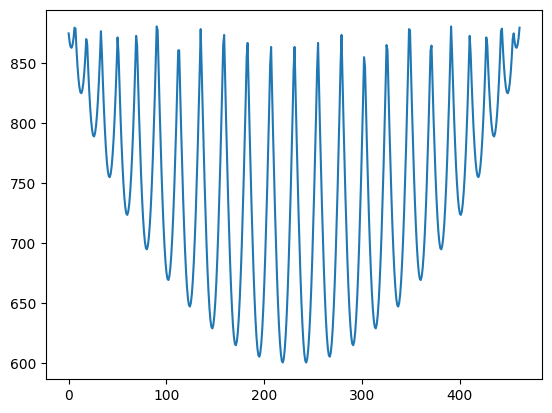

In [17]:
# calculate the distance from the first satellite to the cells

distance = []

for x in range(len(cells)):
    for y in range(len(cells[x])):
        if visible_area_of_sat_one[x,y]:
            position = pl.spherical_to_cartesian(earth_radius, cells[x][y].lat, cells[x][y].longi)
            distance.append(pl.calculate_distance(position[0], position[1],position[2], satellite_position))

print(satellite_position)

distance = jnp.array(distance)
distance
plt.plot(distance)

In [18]:
# Satellite paramterse
satellite_height = 600  # in km
number_of_beams_per_satellite = 19
satellite_bandwidth = 30e6 # in Hz n256
satellite_bandwidth_per_beam = satellite_bandwidth # in Hz
sky_temperature = 290 # in K
satellite_gain = 30 # in dBi
satellite_central_frequency = 2 # in GHz
satellite_power_per_beam = 75.4 # in W

# Full frequency reuse

snr = jax.vmap(pl.calculate_snr, in_axes=(None,None,None,0,None))(satellite_power_per_beam, satellite_gain, satellite_bandwidth, distance, 0)

rates = jax.vmap(pl.calculate_capacity, in_axes=(0,None))(snr, satellite_bandwidth)

rates

Array([17586924., 17826280., 17962172., 17989566., 17907542., 17719092.,
       17430940., 17455506., 18016110., 18497448., 18883532., 19160584.,
       19318132., 19349908., 19254760., 19036450., 18703348., 18267704.,
       17744650., 17899554., 18607290., 19247392., 19799348., 20243680.,
       20563426., 20745552., 20782348., 20672286., 20420044., 20036090.,
       19535632., 18937090., 18260632., 17526636., 18135152., 18984666.,
       19784784., 20512006., 21141940., 21650996., 22018368., 22228016.,
       22270438., 22143672., 21853552., 21413004., 20840686., 20159006.,
       19392322., 18564662., 17698722., 18144890., 19119336., 20068176.,
       20966742., 21787672., 22502008., 23081442., 23500890., 23740732.,
       23789306., 23644188., 23312548., 22810256., 22159934., 21388682.,
       20525380., 19598402., 18633930., 17654718., 17927954., 19000762.,
       20074326., 21125374., 22126134., 23044950., 23848194., 24502346.,
       24977240., 25249366., 25304528., 25139788., 

In [19]:
# Setup the optimization window
import numpy as np


window = 30
time_step = 0.25

R = np.array(rates)
D = np.array(demand)

T = int(window/time_step)
I = np.arange(T)
B = number_of_beams_per_satellite
cell_visible_ids = np.arange(len(distance))

problem = pulp.LpProblem("Satellite_optimization", pulp.LpMaximize)

t = pulp.LpVariable("t", lowBound=0, cat='Continuous')
x = pulp.LpVariable.dicts("x", (I, cell_visible_ids), cat='Binary')

# Objective
problem += t 

# Constraints
for k in cell_visible_ids:
    problem += t <= (R[k] / (T * D[k]+1)) * pulp.lpSum(x[i][k] for i in I)

for i in I:
    problem += B >= pulp.lpSum(x[i][k] for k in cell_visible_ids) 


problem.solve(pulp.PULP_CBC_CMD(msg=True, maxNodes= 1000))


1

In [31]:
# Lets attempt a rewrite in Gurobi
import numpy as np
import gurobipy as gp
from gurobipy import GRB


node_limit = 1000

window = 30
time_step = 0.25

R = np.array(rates)
D = np.array(demand)

T = int(window/time_step)
I = list(range(T)) 
B = number_of_beams_per_satellite
K = list(range(len(distance)))

problem = gp.Model("Satellite_optimization")

t = problem.addVar(name="t", lb=0, vtype=gp.GRB.CONTINUOUS)
x = problem.addVars(I, K, vtype=gp.GRB.BINARY, name="x")

# Objective
problem.setObjective(t, gp.GRB.MAXIMIZE)

# precompute the weight for each cell k
weights = {k: R[k] / (T * D[k] + 1.0) for k in K}

# Constraints

for k in K:
    problem.addConstr(t <= weights[k] * gp.quicksum(x[i, k] for i in I),
                      name=f"Demand Constraint {k}")
    
for i in I:
    problem.addConstr(gp.quicksum(x[i, k] for k in K) <= B,
                    name=f"beam_capacity_time_{i}")
    

# Gurobi parameters
problem.Params.NodeLimit = node_limit
problem.Params.MIPGap    = 1e-4     # tighten or loosen tolerance
# set node limit 


print("Starting Optimisation")

problem.optimize()

 # Extract solution
if problem.Status in {GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.SUBOPTIMAL}:
    sol_t = t.X
    sol_x = {(i, k): x[i, k].X for i in I for k in K if x[i, k].X > 0.5}
    print(f"  t = {sol_t:.6f}")
    print(f"  Active allocations (i,k): {list(sol_x.keys())}")
else:
    print("No feasible solution found.")




Set parameter NodeLimit to value 1000
Set parameter MIPGap to value 0.0001
Starting Optimisation
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
NodeLimit  1000

Optimize a model with 582 rows, 55441 columns and 111342 nonzeros
Model fingerprint: 0x1d7204e4
Variable types: 1 continuous, 55440 integer (55440 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve time: 0.50s
Presolved: 582 rows, 55441 columns, 111342 nonzeros
Variable types: 1 continuous, 55440 integer (55440 binary)

Root relaxation: objective 2.182117e+00, 5392 iterations, 3.24 seconds (2.33 work units)
Total elapsed time = 5.89s (Degen

C/D for each area: [2.19836545e+00 2.22828507e+00 1.99579692e+00 2.09878278e+00
 2.08921313e+00 2.10941553e+00 2.03360963e+00 2.18193841e+00
 2.25201368e+00 2.31218100e+00 2.09817028e+00 2.12895370e+00
 2.25378203e+00 2.25748944e+00 2.13941789e+00 2.11516118e+00
 2.33791852e+00 2.02974486e+00 2.07020926e+00 1.98883939e+00
 2.32591128e+00 2.13859916e+00 2.19992757e+00 2.16896582e+00
 2.57042837e+00 2.59319401e+00 2.30914974e+00 2.29692078e+00
 2.04200435e+00 2.22623229e+00 2.17062569e+00 2.10412121e+00
 3.04343867e+00 2.43425512e+00 2.26689410e+00 3.16411090e+00
 3.29746389e+00 2.05120063e+00 2.64274240e+00 2.40566611e+00
 2.14067459e+00 2.22280169e+00 2.16518164e+00 2.46040797e+00
 2.42817235e+00 2.37922263e+00 1.98482728e+00 2.15989351e+00
 2.15470243e+00 2.06274033e+00 1.96652472e+00 2.01609898e+00
 2.04850030e+00 2.50852203e+00 1.96563196e+00 2.42085242e+00
 2.50022316e+00 2.56460476e+00 1.95840752e+00 1.97839427e+00
 1.98244214e+00 1.97034883e+00 2.59028316e+00 2.85128188e+00
 2.46

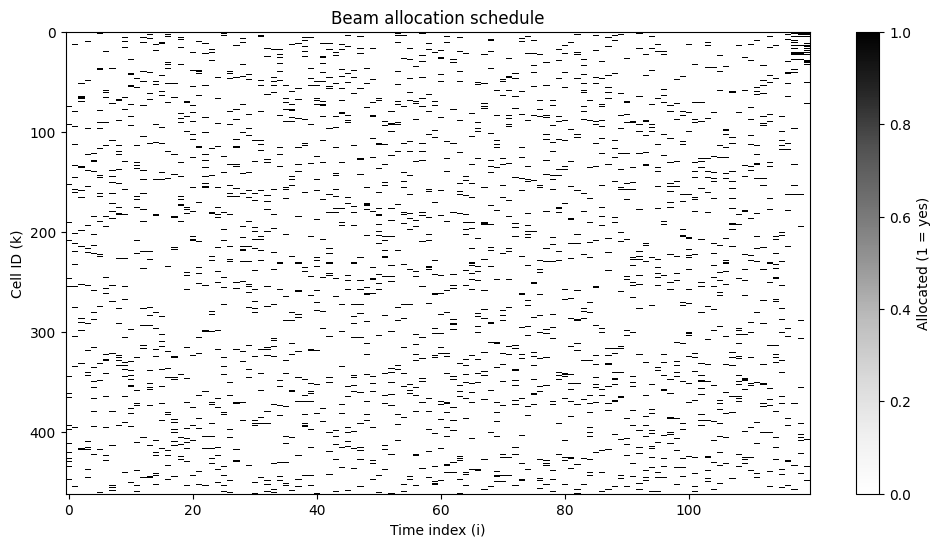

In [ ]:
schedule_gurobi = np.zeros((len(I), len(K)))  # rows = time steps, columns = cells

for i_idx, i in enumerate(I):
    for k_idx, k in enumerate(K):
        if x[i, k].X > 0.5:
            schedule_gurobi[i_idx, k_idx] = 1

# Calculate the C/D for each area
C_D = np.zeros(len(demand))
for i in range(len(demand)):
    C_D[i] = rates[i] * np.sum(schedule_gurobi[:, i]) / (demand[i]*T+1e-10)  # Avoid division by zero
print("C/D for each area:", C_D)
print("C/D mean:", np.mean(C_D))

plt.figure(figsize=(12, 6))
plt.imshow(schedule_gurobi.T, aspect='auto', cmap='Greys', interpolation='none')
plt.xlabel("Time index (i)")
plt.ylabel("Cell ID (k)")
plt.title("Beam allocation schedule")
plt.colorbar(label="Allocated (1 = yes)")
plt.show()



In [20]:
# Results
print("Status:", pulp.LpStatus[problem.status])
print("Optimal t:", pulp.value(t))
print("Selected (i, k) pairs where x[i][k] = 1:")

Status: Optimal
Optimal t: 1.8042496
Selected (i, k) pairs where x[i][k] = 1:


In [21]:
schedule = np.zeros((T, cell_visible_ids.shape[0]))
for i in I:
    for k in cell_visible_ids:
        if pulp.value(x[i][k]) == 1:
            schedule[i][k] = 1

Text(0.5, 1.0, 'Beam Allocation Schedule')

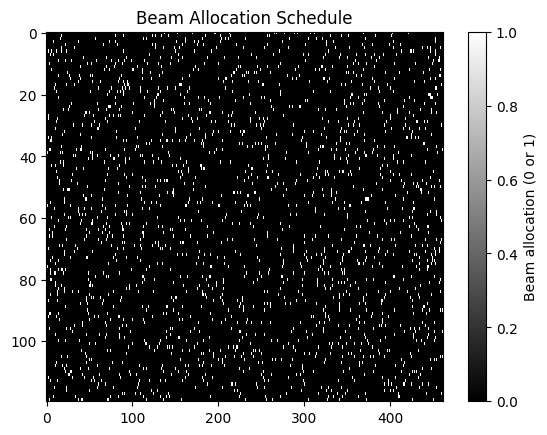

In [22]:
plt.imshow(schedule, cmap='gray', aspect='auto', interpolation='none')
plt.colorbar(label='Beam allocation (0 or 1)')
plt.title("Beam Allocation Schedule")

In [ ]:
# Calculate the C/D for each area
C_D = np.zeros(len(demand))
for i in range(len(demand)):
    C_D[i] = rates[i] * np.sum(schedule[:, i]) / (demand[i]*T)
print("C/D for each area:", C_D)
print("C/D mean:", np.mean(C_D))

C/D for each area: [0.41752407 0.45299229 0.42638019 0.53524578 0.53524578 0.5329752
 0.70465469 0.52190506 0.52425015 0.71696323 0.54949731 0.55929852
 0.5668841  0.57205689 0.38311991 0.76623982 0.65377933 0.42516309
 0.74573141 0.54949731 0.53772241 0.69900024 0.44945592 0.54250592
 0.41958916 0.76647055 0.78447694 0.79950738 0.69529152 0.61435556
 0.61738741 0.61738741 0.52659047 0.60838008 0.79950738 0.58835769
 0.57485288 0.55945224 0.72334123 0.6991536  0.71418202 0.74275386
 0.77016282 0.79588175 0.46088472 0.63000286 0.64297754 0.8707577
 0.75425881 0.88464719 0.88464719 0.65997648 0.6530683  0.73483145
 0.84000385 0.70230055 0.79588175 0.57762212 0.74275386 0.71418202
 0.51796764 0.72351658 0.56721926 0.59135211 0.81948709 0.63654751
 0.87552708 0.77074862 0.91910684 0.70097142 0.94527268 0.95068955
 0.81487674 0.56716359 0.80111021 0.6893301  0.67440504 0.6566453
 0.63654751 0.61461532 0.59135211 0.75629234 1.08527493 0.69062358
 0.59196305 0.54501283 0.76325256 0.59991181 0

In [ ]:
np.mean(rates)

Array(18967318., dtype=float32)

In [ ]:
# count how many have C/D = 0
count = 0
for i in range(len(demand)):
    if C_D[i] == 0:
        count += 1

print("Number of areas with C/D = 0:", count)

# count how many have C/D > 1
count = 0
for i in range(len(demand)):
    if C_D[i] > 0:
        count += 1

print("Number of areas with C/D > 1:", count)

Number of areas with C/D = 0: 0
Number of areas with C/D > 1: 912


In [ ]:
# Okay then evolve the demand over time, the cells have been intialised and then since it is a markov process, the demand can be calculated based on the state change of the users.


# Create a list of cells that are within the visible area of the satellite
cells_within_visible_area = [] 
for i in range(len(cells)):
    for j in range(len(cells[i])):
        if visible_area_of_sat_one[i,j]:
            cells_within_visible_area.append(cells[i][j])

cells_within_visible_area[0]

square_cell(lat=Array(-0.13002127, dtype=float32), longi=Array(-0.02758027, dtype=float32), lat_width=[], longi_width=[], density=Array(8, dtype=int32), id=13, users=[User(id=0 
 lat=-0.13002127408981323 
 lon=-0.027580270543694496 
 demand=0.0 
 position=[0. 0. 0.]), User(id=1 
 lat=-0.13002127408981323 
 lon=-0.027580270543694496 
 demand=0.0 
 position=[0. 0. 0.]), User(id=2 
 lat=-0.13002127408981323 
 lon=-0.027580270543694496 
 demand=100000.0 
 position=[0. 0. 0.]), User(id=3 
 lat=-0.13002127408981323 
 lon=-0.027580270543694496 
 demand=100000.0 
 position=[0. 0. 0.]), User(id=4 
 lat=-0.13002127408981323 
 lon=-0.027580270543694496 
 demand=100000.0 
 position=[0. 0. 0.]), User(id=5 
 lat=-0.13002127408981323 
 lon=-0.027580270543694496 
 demand=0.0 
 position=[0. 0. 0.]), User(id=6 
 lat=-0.13002127408981323 
 lon=-0.027580270543694496 
 demand=100000.0 
 position=[0. 0. 0.]), User(id=7 
 lat=-0.13002127408981323 
 lon=-0.027580270543694496 
 demand=100000.0 
 position=[0. 0

In [ ]:
test = []

A = jnp.array([[0.1, 0.9],
            [0.3, 0.7]])

# the amount of state changes
state_changes = 2

# Vectorise the user vector
users_state_change = jax.jit(jax.vmap(user_state_change, in_axes=(None, 0, 0, 0)))
for k in range(len(cells_within_visible_area)):
    time_series = jnp.zeros((cells_within_visible_area[k].density, state_changes+1))
    
    # The intital state is the demand of the user
    states = jnp.array([1 if cells_within_visible_area[k].users[x].demand > 0  else 0 for x in range(cells_within_visible_area[k].density.item())])

    # Intialize the keys
    key = jrandom.PRNGKey(seed)
    seed += 1
    keys = jrandom.split(key, (cells_within_visible_area[k].density.item(), 1))[:,0]

    # Calcuate the state change
    test.append(users_state_change(A, states, time_series, keys))

In [ ]:
schedule.shape

(120, 912)

In [ ]:
# Calculate the demand of the cells over time given test
demand_over_time = []
for tes in test:
    demand_over_time.append(jnp.sum(tes, axis=0)*100e3)

demand_over_time = jnp.array(demand_over_time)

demand_over_time

Array([[500000., 700000., 500000.],
       [700000., 600000., 700000.],
       [500000., 300000., 700000.],
       ...,
       [800000., 400000., 700000.],
       [600000., 700000., 700000.],
       [300000., 200000., 300000.]], dtype=float32)

In [ ]:
# Loop over the cells and calculate the over allocation vs under allocation of demand. Over allocation is not too bad under allocation is bad.
# Okay lets try and say that there is a demand over and under allocation.

# Over allocation is when the demand is less than the capacity
# Under allocation is when the demand is over than the capacity

#  But first lets just calcualte the difference in average
average_demand_over_time = jnp.mean(jnp.divide(jnp.multiply(jnp.mean(schedule, axis=0), rates), jnp.mean(demand_over_time)))

print(f"Demand over time {average_demand_over_time}")



Demand over time 0.9336062669754028
